# Борьба со смещением в CausalInference с помощью Propensity Score Matching

Ищем похожих пользователей по набору признаков из контрольной группы, чтобы убрать смещение связанное с этими признаками и смотреть только на разницу в воздействии

In [235]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score

In [236]:
df = sns.load_dataset('titanic')
df['is_pclass3'] = df['pclass']==3
df['is_female'] = df['sex']=='female'
df = df.filter(['survived', 'is_pclass3', 'is_female', 'age'])\
       .dropna().reset_index(drop=True)
df

,survived,is_pclass3,is_female,age
0,0,True,False,22.00
1,1,False,True,38.00
2,1,True,True,26.00
3,1,False,True,35.00
4,0,True,False,35.00
...,...,...,...,...
709,0,True,True,39.00
710,0,False,False,27.00
711,1,False,True,19.00
712,1,False,False,26.00


In [237]:
TREATMENT = 'is_pclass3'
OUTCOME = 'survived'
df.groupby(TREATMENT)[OUTCOME].describe()

,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,0.57,0.50,0.00,0.00,1.00,1.00,1.00
True,355.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00


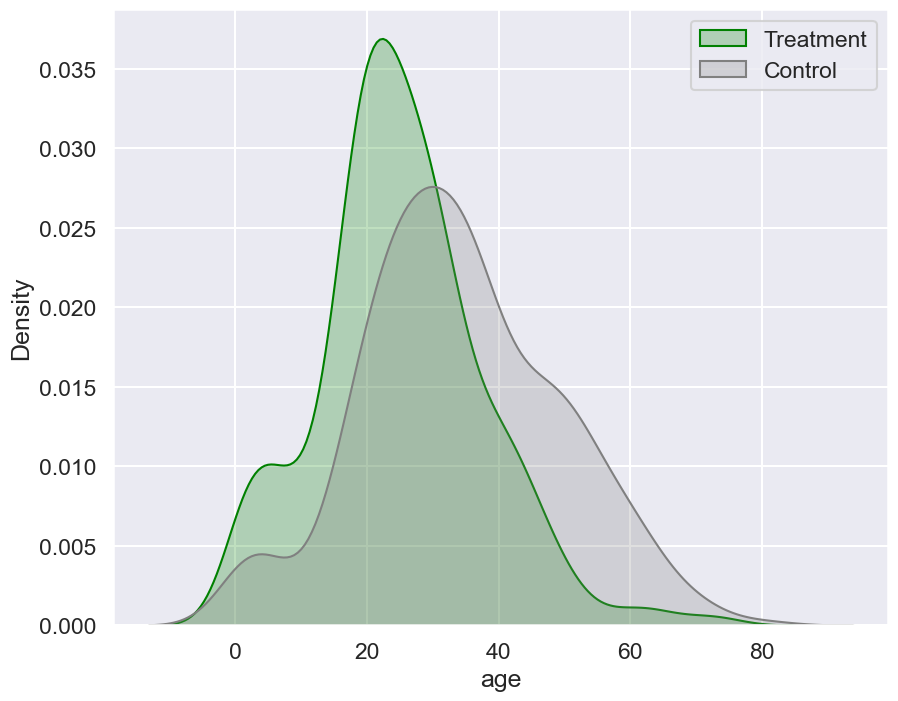

In [238]:
T_LABEL = 'Treatment'
C_LABEL = 'Control'

sns.kdeplot(df[df[TREATMENT]], x='age', fill=True, color='green', label=T_LABEL)
sns.kdeplot(df[~df[TREATMENT]], x='age', fill=True, color='grey', label=C_LABEL)

plt.legend();

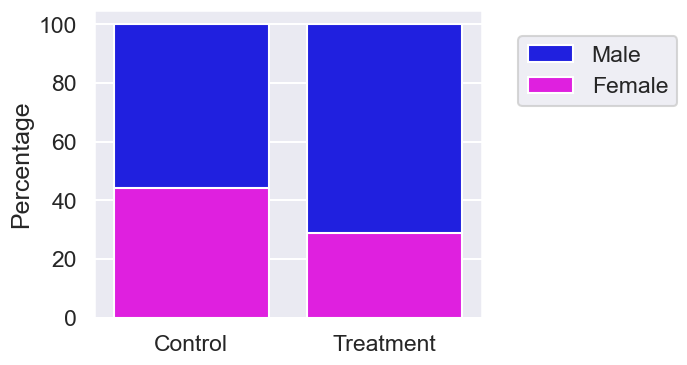

In [239]:
F_COLOUR = 'magenta'
M_COLOUR = 'blue'
F_LABEL = 'Female'
M_LABEL = 'Male'
gender = 100 * pd.crosstab(df[TREATMENT].replace({True: T_LABEL, 
                                                  False: C_LABEL}), 
                           df['is_female'].replace({True: 'Female',
                                                    False: 'Male'}), 
                           normalize='index')
gender['All'] = 100
plt.figure(figsize=(5, 4))
sns.barplot(data=gender, x=gender.index.astype(str),  y="All", 
            color=M_COLOUR, label=M_LABEL)
sns.barplot(data=gender, x=gender.index.astype(str),  y='Female', 
            color=F_COLOUR, label=F_LABEL)
plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
plt.xlabel('')
plt.ylabel('Percentage');

In [240]:
# нужно на признаках обучить модель, предсказывающую флаг воздействия
X = df[['is_female', 'age']].astype(float)
t = df[TREATMENT].astype(int)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LogisticRegression())
])

model.fit(X, t)

threshold = 0.5
df['proba'] = model.predict_proba(X)[:,1]
df['logit'] = df['proba'].apply(lambda p: np.log(p/(1-p)))
df['pred'] = np.where(df['proba']>=threshold, 1, 0)
df.head()

# мы не разбиваем данные на обучающую и тестовую выборки, потому что мы не строим предиктивную модель

,survived,is_pclass3,is_female,age,proba,logit,pred
0,0,True,False,22.00,0.67,0.70,1
1,1,False,True,38.00,0.26,-1.02,0
2,1,True,True,26.00,0.40,-0.40,0
3,1,False,True,35.00,0.30,-0.87,0
4,0,True,False,35.00,0.51,0.03,1


In [241]:
print(f"Accuracy: {np.mean(df[TREATMENT]==df['pred']):.4f},\
 ROC AUC: {roc_auc_score(df[TREATMENT], df['proba']):.4f},\
 F1-score: {f1_score(df[TREATMENT], df['pred']):.4f}")
# Visualise confusion matrix
pd.crosstab(df[TREATMENT], df['pred']).rename(columns={0: False, 
                                                       1:True})

Accuracy: 0.6695, ROC AUC: 0.7197, F1-score: 0.6776


pred,False,True
is_pclass3,,
False,230,129
True,107,248


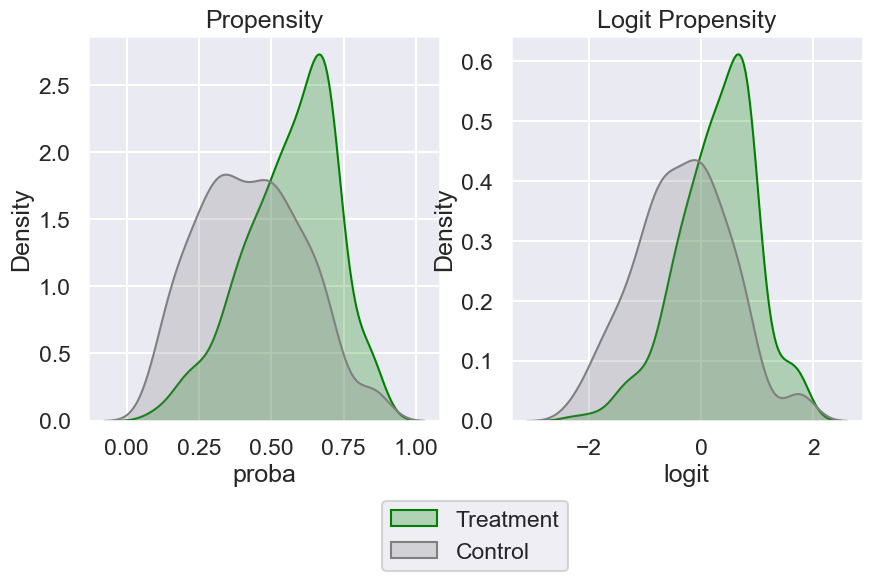

In [242]:
# визуализируем полученные propensity scores и их логиты
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.kdeplot(df[df[TREATMENT]], x='proba', color='green', fill=True, label=T_LABEL, ax=ax[0])
sns.kdeplot(df[~df[TREATMENT]], x='proba', color='grey', fill=True, label=C_LABEL, ax=ax[0])
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))

sns.kdeplot(df[df[TREATMENT]], x='logit', color='green', fill=True, label=T_LABEL, ax=ax[1])
sns.kdeplot(df[~df[TREATMENT]], x='logit', color='grey', fill=True, label=C_LABEL, ax=ax[1])
ax[1].set_title('Logit Propensity');

# видно пересечение между целевой и контрольной группами, что хорошо, так как значит мы сможем сматчить

In [243]:
# проведем матчинг 1 к 1, может быть так, что несколько записей из контрольной группы попадут в выборку, а какие-то не попадут вовсе
df.sort_values('logit', inplace=True)
control_subset = df[~df[TREATMENT]]

for i, row in df[df[TREATMENT]].iterrows():
    logit = row['logit']

    # ищем минимальную разницу из контрольной группы
    distances = np.sqrt((control_subset['logit'] - logit)**2)
    min_distance = min(distances)
    iloc_idx = (distances).argmin()
    matched_index = control_subset.iloc[iloc_idx].name
    df.loc[i, 'match'] = matched_index
    df.loc[i, 'distance'] = min_distance

In [244]:
df[df[TREATMENT]]

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
385,1,True,True,63.00,0.09,-2.33,0,221.00,0.00
679,0,True,False,74.00,0.12,-2.01,0,616.00,0.01
91,0,True,False,70.50,0.14,-1.82,0,452.00,0.02
586,0,True,True,48.00,0.18,-1.55,0,442.00,0.00
225,0,True,False,65.00,0.18,-1.54,0,40.00,0.00
...,...,...,...,...,...,...,...,...,...
6,0,True,False,2.00,0.85,1.75,1,273.00,0.00
132,0,True,False,1.00,0.86,1.80,1,661.00,0.00
628,1,True,False,1.00,0.86,1.80,1,661.00,0.00
309,0,True,False,1.00,0.86,1.80,1,661.00,0.00


In [245]:
# объединим сматченные записи
indices = df[df['match'].notna()].index.\
          append(pd.Index(df.loc[df['match'].notna(), 'match']))
matched_df = df.loc[indices].reset_index(drop=True)
matched_df

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
0,1,True,True,63.00,0.09,-2.33,0,221.00,0.00
1,0,True,False,74.00,0.12,-2.01,0,616.00,0.01
2,0,True,False,70.50,0.14,-1.82,0,452.00,0.02
3,0,True,True,48.00,0.18,-1.55,0,442.00,0.00
4,0,True,False,65.00,0.18,-1.54,0,40.00,0.00
...,...,...,...,...,...,...,...,...,...
705,1,False,False,2.00,0.85,1.75,1,NaN,NaN
706,1,False,False,1.00,0.86,1.80,1,NaN,NaN
707,1,False,False,1.00,0.86,1.80,1,NaN,NaN
708,1,False,False,1.00,0.86,1.80,1,NaN,NaN


In [246]:
COLUMNS = ['age', 'is_female', OUTCOME]
matches = pd.merge(df.loc[df[TREATMENT], COLUMNS+['match']], 
                   df[COLUMNS], left_on='match', 
                   right_index=True, 
                   how='left', suffixes=('_t', '_c'))
matches

,age_t,is_female_t,survived_t,match,age_c,is_female_c,survived_c
385,63.00,True,1,221.00,63.00,True,1
679,74.00,False,0,616.00,57.00,True,0
91,70.50,False,0,452.00,53.00,True,1
586,48.00,True,0,442.00,48.00,True,1
225,65.00,False,0,40.00,65.00,False,0
...,...,...,...,...,...,...,...
6,2.00,False,0,273.00,2.00,False,1
132,1.00,False,0,661.00,1.00,False,1
628,1.00,False,1,661.00,1.00,False,1
309,1.00,False,0,661.00,1.00,False,1


In [247]:
for var in ['logit', 'age']:
    print(f"{var} | Before matching")
    display(df.groupby(TREATMENT)[var].describe())
    print(f"{var} | After matching")
    display(matched_df.groupby(TREATMENT)[var].describe())

logit | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,-0.33,0.84,-2.33,-0.87,-0.29,0.24,1.82
True,355.00,0.28,0.71,-2.33,-0.18,0.38,0.76,1.83


logit | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,355.00,0.28,0.70,-2.33,-0.18,0.39,0.76,1.82
True,355.00,0.28,0.71,-2.33,-0.18,0.38,0.76,1.83


age | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,34.21,15.00,0.67,24.00,33.00,45.00,80.00
True,355.00,25.14,12.50,0.42,18.00,24.00,32.00,74.00


age | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,355.00,24.67,12.55,0.67,18.00,24.00,32.00,65.00
True,355.00,25.14,12.50,0.42,18.00,24.00,32.00,74.00


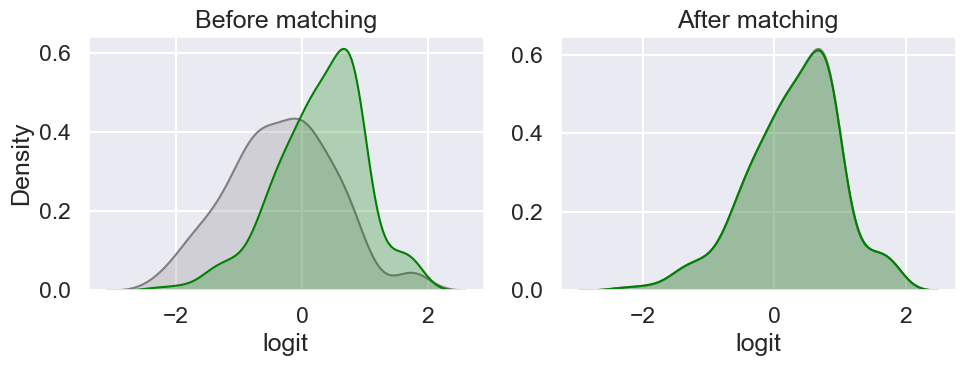

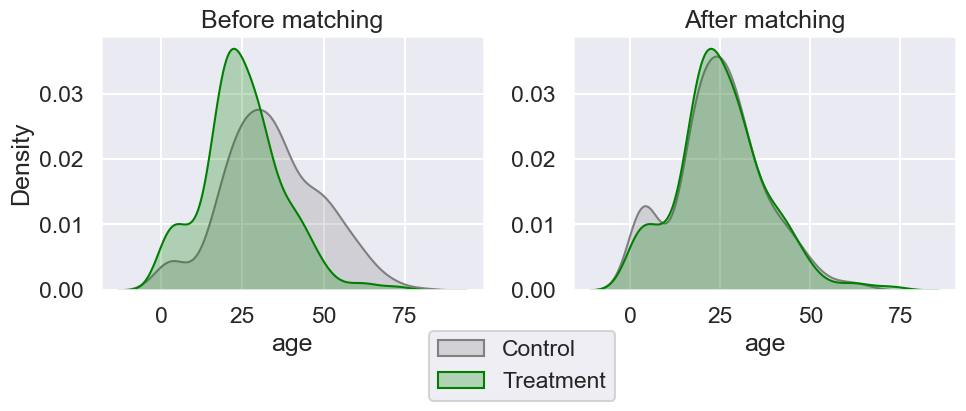

In [248]:
for var in ['logit', 'age']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # Visualise original distribution
    sns.kdeplot(data=df[~df[TREATMENT]], x=var, fill=True, 
                color='grey', label=C_LABEL, ax=ax[0])
    sns.kdeplot(data=df[df[TREATMENT]], x=var, fill=True, 
                color='green', label=T_LABEL, ax=ax[0])
    ax[0].set_title('Before matching')
    
    # Visualise new distribution
    sns.kdeplot(data=matched_df[~matched_df[TREATMENT]], x=var, 
                fill=True, color='grey', label=C_LABEL, ax=ax[1])
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]], x=var, 
                fill=True, color='green', label=T_LABEL, ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

In [249]:
print(f"{'is_female'} | Before matching")
display(pd.crosstab(df[TREATMENT], df['is_female'], 
                    normalize='index'))
print(f"{'is_female'} | After matching")
display(pd.crosstab(matched_df[TREATMENT], matched_df['is_female'], 
            normalize='index'))

is_female | Before matching


is_female,False,True
is_pclass3,,
False,0.56,0.44
True,0.71,0.29


is_female | After matching


is_female,False,True
is_pclass3,,
False,0.68,0.32
True,0.71,0.29


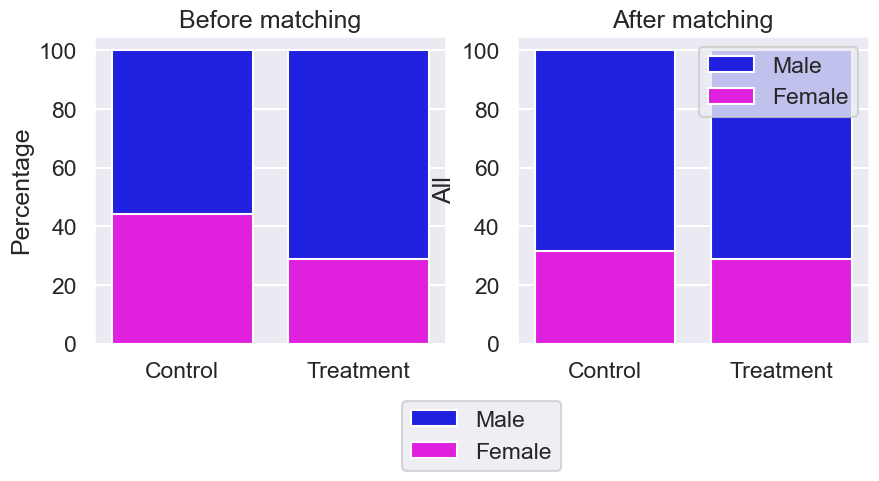

In [250]:
# видно, что распределения в группах стали ровнее

# Visualise new distribution
gender_after = 100 * pd.crosstab(
    matched_df[TREATMENT].replace({True: T_LABEL, False: C_LABEL}), 
    matched_df['is_female'].replace({True: 'Female', False: 'Male'}), 
    normalize='index'
)
gender_after['All'] = 100

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Visualise original distribution
sns.barplot(data=gender, x=gender.index.astype(str), y="All", 
            color=M_COLOUR, label=M_LABEL, ax=ax[0])
sns.barplot(data=gender, x=gender.index.astype(str), y='Female', 
            color=F_COLOUR, label=F_LABEL, ax=ax[0])
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Before matching')


sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y="All", color=M_COLOUR, label=M_LABEL, ax=ax[1])
sns.barplot(data=gender_after, x=gender_after.index.astype(str), 
            y='Female', color=F_COLOUR, label=F_LABEL, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_title('After matching');

In [251]:
summary = matched_df.groupby(TREATMENT)[OUTCOME]\
                    .aggregate(['mean', 'std', 'count'])
summary

,mean,std,count
is_pclass3,,,
False,0.57,0.50,355
True,0.24,0.43,355


In [252]:
c_outcome = summary.loc[False, 'mean']
t_outcome =  summary.loc[True, 'mean']
att = t_outcome - c_outcome
print('The Average Treatment Effect on Treated (ATT): {:.4f}'\
      .format(att))

The Average Treatment Effect on Treated (ATT): -0.3324


In [253]:
from sklift.models import TwoModels
from sklift.metrics import qini_auc_score
from sklift.viz import plot_uplift_curve
from catboost import CatBoostClassifier

uplift_model = TwoModels(estimator_ctrl=CatBoostClassifier(verbose=100), estimator_trmnt=CatBoostClassifier(verbose=100))

In [254]:
uplift_model.fit(X=matched_df[['is_female', 'age']], y=matched_df['survived'], treatment=matched_df[TREATMENT])

Learning rate set to 0.00662
0:	learn: 0.6881980	total: 1.01ms	remaining: 1.01s
100:	learn: 0.4703919	total: 37.5ms	remaining: 334ms
200:	learn: 0.3684863	total: 63.8ms	remaining: 254ms
300:	learn: 0.2951471	total: 83.9ms	remaining: 195ms
400:	learn: 0.2464952	total: 104ms	remaining: 155ms
500:	learn: 0.2148411	total: 127ms	remaining: 126ms
600:	learn: 0.1848280	total: 146ms	remaining: 96.9ms
700:	learn: 0.1591806	total: 166ms	remaining: 70.6ms
800:	learn: 0.1340392	total: 186ms	remaining: 46.2ms
900:	learn: 0.1140436	total: 206ms	remaining: 22.6ms
999:	learn: 0.0976774	total: 226ms	remaining: 0us
Learning rate set to 0.00662
0:	learn: 0.6900469	total: 225us	remaining: 225ms
100:	learn: 0.5275465	total: 19.4ms	remaining: 173ms
200:	learn: 0.4822339	total: 39.9ms	remaining: 159ms
300:	learn: 0.4641460	total: 58.1ms	remaining: 135ms
400:	learn: 0.4526021	total: 76.9ms	remaining: 115ms
500:	learn: 0.4442589	total: 95.6ms	remaining: 95.2ms
600:	learn: 0.4368221	total: 114ms	remaining: 76ms

TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x31d2d8410>,
          estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x31d2264d0>)

In [255]:
predicted_uplift = uplift_model.predict(matched_df[['is_female', 'age']])

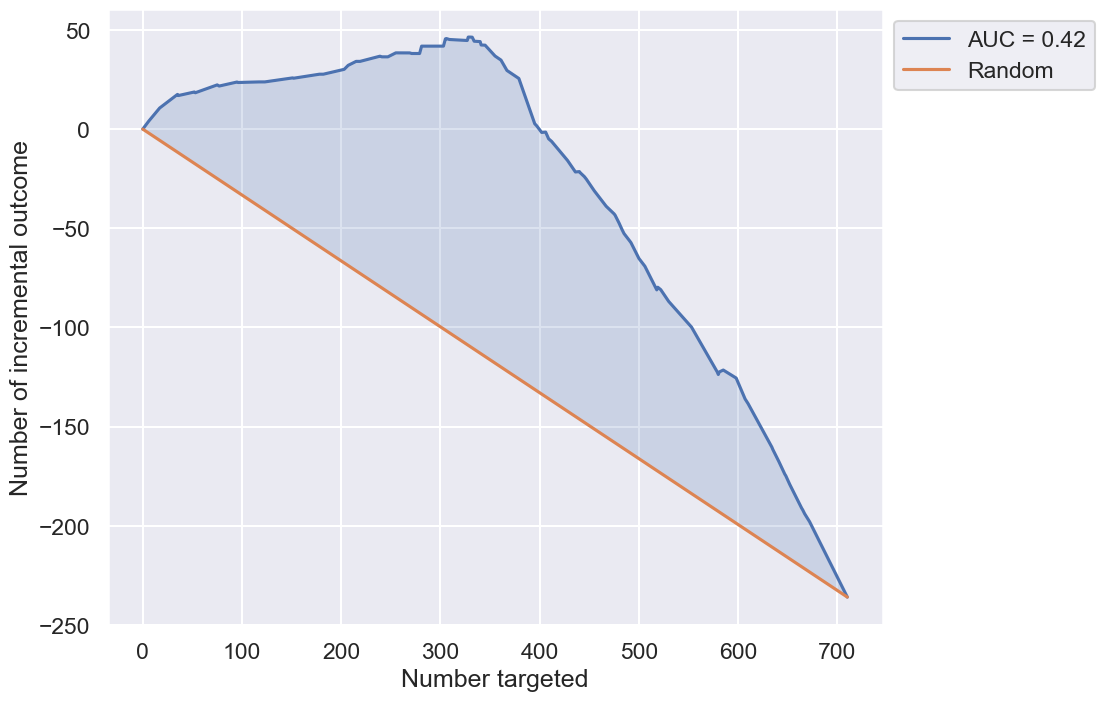

In [256]:
plot_uplift_curve(matched_df['survived'], predicted_uplift, matched_df[TREATMENT], perfect=False);

In [257]:
matched_df['uplift'] = predicted_uplift

In [258]:
matched_df.sort_values('uplift', ascending=False).head(15)

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance,uplift
412,0,False,True,26.00,0.40,-0.40,0,NaN,NaN,0.29
410,0,False,True,26.00,0.40,-0.40,0,NaN,NaN,0.29
57,0,True,True,26.00,0.40,-0.40,0,249.00,0.00,0.29
55,1,True,True,26.00,0.40,-0.40,0,249.00,0.00,0.29
411,0,False,True,26.00,0.40,-0.40,0,NaN,NaN,0.29
56,1,True,True,26.00,0.40,-0.40,0,249.00,0.00,0.29
189,0,True,False,27.00,0.61,0.44,1,301.00,0.00,0.19
192,1,True,False,27.00,0.61,0.44,1,301.00,0.00,0.19
193,1,True,False,27.00,0.61,0.44,1,301.00,0.00,0.19
548,0,False,False,27.00,0.61,0.44,1,NaN,NaN,0.19


# PSMPy

In [179]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

In [222]:
df = sns.load_dataset('titanic')
df['is_pclass3'] = df['pclass']==3
df['is_female'] = df['sex']=='female'
df = df.filter(['survived', 'is_pclass3', 'is_female', 'age'])\
       .dropna().reset_index(drop=True)
df = df.reset_index()
df

,index,survived,is_pclass3,is_female,age
0,0,0,True,False,22.00
1,1,1,False,True,38.00
2,2,1,True,True,26.00
3,3,1,False,True,35.00
4,4,0,True,False,35.00
...,...,...,...,...,...
709,709,0,True,True,39.00
710,710,0,False,False,27.00
711,711,1,False,True,19.00
712,712,1,False,False,26.00


In [223]:
psm = PsmPy(df, treatment='is_pclass3', indx='index', exclude=['survived'])

In [224]:
psm.logistic_ps(balance=False)

In [225]:
psm.predicted_data

,index,is_female,age,propensity_score,propensity_logit,is_pclass3
0,1,True,38.00,0.27,-0.99,0
1,3,True,35.00,0.30,-0.84,0
2,5,False,54.00,0.28,-0.95,0
3,8,True,14.00,0.55,0.22,0
4,10,True,58.00,0.12,-2.00,0
...,...,...,...,...,...,...
709,705,False,33.00,0.53,0.11,1
710,706,True,22.00,0.45,-0.19,1
711,708,False,25.00,0.63,0.51,1
712,709,True,39.00,0.26,-1.04,1


In [230]:
psm.knn_matched(matcher='propensity_logit', replacement=True, caliper=None, drop_unmatched=False)

In [231]:
psm.df_matched

,index,is_female,age,propensity_score,propensity_logit,is_pclass3
0,0,False,22.00,0.66,0.66,1
1,2,True,26.00,0.40,-0.39,1
2,4,False,35.00,0.50,0.01,1
3,6,False,2.00,0.84,1.67,1
4,7,True,27.00,0.39,-0.44,1
...,...,...,...,...,...,...
705,193,False,33.00,0.53,0.11,0
706,122,True,22.00,0.45,-0.19,0
707,527,False,25.00,0.63,0.51,0
708,443,True,39.00,0.26,-1.04,0


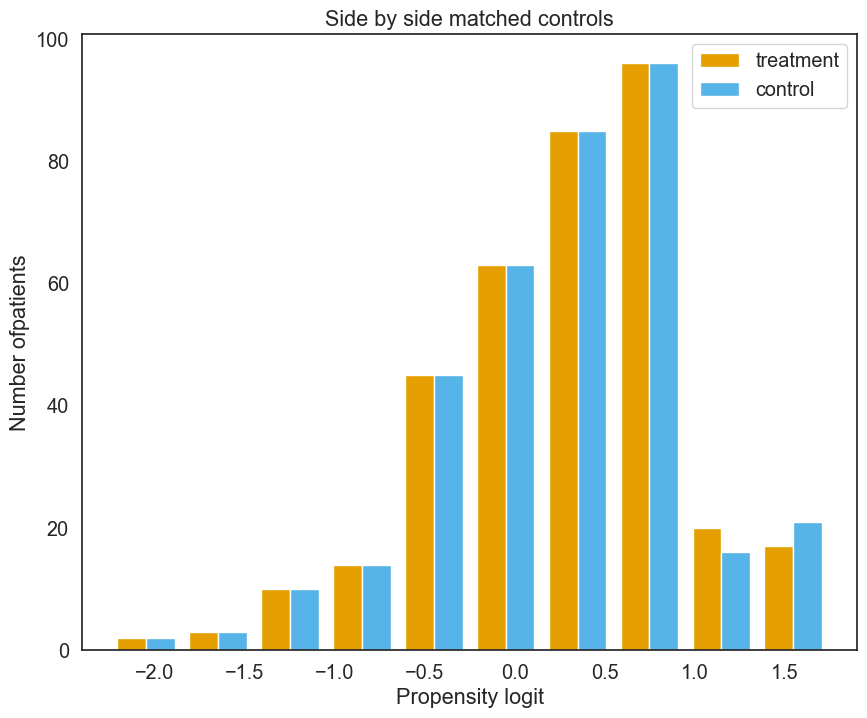

In [232]:
psm.plot_match(Title='Side by side matched controls', Ylabel='Number ofpatients', Xlabel= 'Propensity logit', names = ['treatment', 'control'], colors=['#E69F00', '#56B4E9'] ,save=True)

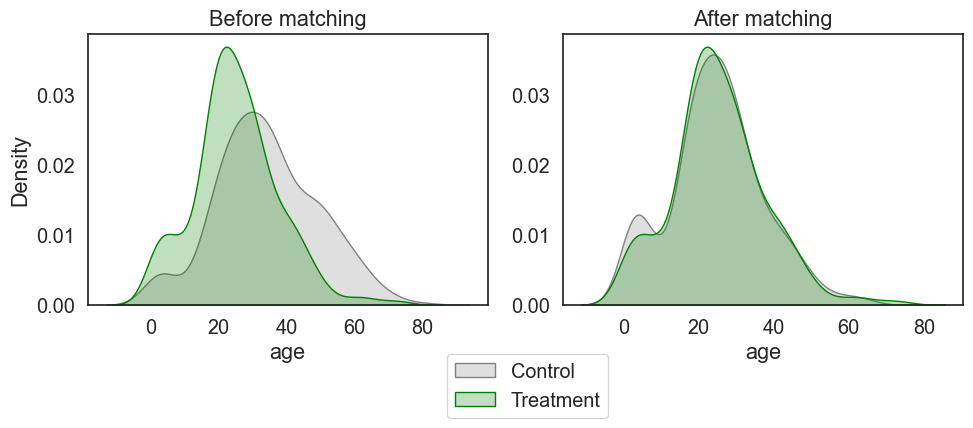

In [233]:
var = 'age'
fig, ax = plt.subplots(1,2,figsize=(10,4))
# Visualise original distribution
sns.kdeplot(data=df[~df[TREATMENT]], x=var, fill=True, 
            color='grey', label=C_LABEL, ax=ax[0])
sns.kdeplot(data=df[df[TREATMENT]], x=var, fill=True, 
            color='green', label=T_LABEL, ax=ax[0])
ax[0].set_title('Before matching')

# Visualise new distribution
sns.kdeplot(data=psm.df_matched[~psm.df_matched[TREATMENT].astype(bool)], x=var, 
            fill=True, color='grey', label=C_LABEL, ax=ax[1])
sns.kdeplot(data=psm.df_matched[psm.df_matched[TREATMENT].astype(bool)], x=var, 
            fill=True, color='green', label=T_LABEL, ax=ax[1])
ax[1].set_title('After matching')
ax[1].set_ylabel("")
plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

In [234]:
summary = psm.df_matched.merge(df[['index', 'survived']], on='index', how='left').groupby(TREATMENT)[OUTCOME]\
                    .aggregate(['mean', 'std', 'count'])
summary

,mean,std,count
is_pclass3,,,
0,0.56,0.50,355
1,0.24,0.43,355
